In [1]:
import os
import numpy as np
import sys

import tensorflow as tf
from keras import layers
from keras.layers import InputLayer,Conv2D,Dropout,MaxPooling2D,Conv2DTranspose,BatchNormalization

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [2]:
from keras.models import Sequential

In [3]:
left_files =[]
right_files =[]
depth_files=[]
path = 'images'
for x in os.listdir(path):
    for z in os.listdir(path+'/'+x):
        if z.endswith("left.jpeg"):
            left_files.append(path+'/'+x+'/'+z)
    for y in os.listdir(path+'/'+x):
        if y.endswith("right.jpeg"):
            right_files.append(path+'/'+x+'/'+y)
    for r in os.listdir(path+'/'+x):
        if r.endswith("depth.jpeg"):
            depth_files.append(path+'/'+x+'/'+r)
left_files=np.array(left_files)
right_files=np.array(right_files)
depth_files=np.array(depth_files)
print(left_files.shape)
print(right_files.shape)
print(depth_files.shape)

(1803,)
(1803,)
(1803,)


In [4]:
def preprocess(img):
    img =cv2.imread(img)
    img= cv2.resize(img,(128,128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img=img / 255
    return img

In [5]:
left=[]
right =[]
depth =[]

In [6]:
for x in right_files:
    left.append(preprocess(x))
left=np.array(left)
print(left.shape)
for y in right_files:
    right.append(preprocess(y))
right=np.array(right)
print(right.shape)
for z in depth_files:
    depth.append(preprocess(z))
depth=np.array(depth)
print(depth.shape)
    

(1803, 128, 128)
(1803, 128, 128)
(1803, 128, 128)


In [56]:
left = np.reshape(left , (1803,128,128,1))
right = np.reshape(right , (1803,128,128,1))
depth = np.reshape(depth, (1803,128,128,1))

In [57]:
images= np.concatenate((left,right),axis=3)
print(images.shape)

(1803, 128, 128, 2)


In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((left,right,depth))


In [59]:
del train_dataset

In [8]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

In [11]:
data ={"left":left_files,"right":right_files,"depth":depth_files}
df =pd.DataFrame(data)
df.head

<bound method NDFrame.head of                             left                        right  \
0       images/part1/0-left.jpeg    images/part1/0-right.jpeg   
1       images/part1/1-left.jpeg    images/part1/1-right.jpeg   
2      images/part1/10-left.jpeg   images/part1/10-right.jpeg   
3     images/part1/100-left.jpeg  images/part1/100-right.jpeg   
4     images/part1/101-left.jpeg  images/part1/101-right.jpeg   
...                          ...                          ...   
1798   images/part6/95-left.jpeg   images/part6/95-right.jpeg   
1799   images/part6/96-left.jpeg   images/part6/96-right.jpeg   
1800   images/part6/97-left.jpeg   images/part6/97-right.jpeg   
1801   images/part6/98-left.jpeg   images/part6/98-right.jpeg   
1802   images/part6/99-left.jpeg   images/part6/99-right.jpeg   

                            depth  
0       images/part1/0-depth.jpeg  
1       images/part1/1-depth.jpeg  
2      images/part1/10-depth.jpeg  
3     images/part1/100-depth.jpeg  
4     ima

In [12]:
HEIGHT = 256
WIDTH = 256
LR = 0.0002
EPOCHS = 30
BATCH_SIZE = 30

In [13]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=30, dim=(256, 256), n_channels=3, shuffle=True):
        """
        Initialization
        """
        self.data = data
        self.indices = self.data.index.tolist()
        self.dim = dim
        self.n_channels = n_channels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.min_depth = 0.1
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.indices):
            self.batch_size = len(self.indices) - index * self.batch_size
        # Generate one batch of data
        # Generate indices of the batch
        index = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
        # Find list of IDs
        batch = [self.indices[k] for k in index]
        images,d = self.data_generation(batch)

        return images,d

    def on_epoch_end(self):

        """
        Updates indexes after each epoch
        """
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def load(self, leftpath, right_path,depth_path):
        """Load input and target image."""

        left = cv2.imread(leftpath)
        left = cv2.cvtColor(left, cv2.COLOR_BGR2RGB)
        left = cv2.resize(left, self.dim)
        left = tf.image.convert_image_dtype(left, tf.float32)
        right = cv2.imread(right_path)
        right = cv2.cvtColor(right, cv2.COLOR_BGR2RGB)
        right = cv2.resize(right, self.dim)
        right= tf.image.convert_image_dtype(right, tf.float32)
        image = np.concatenate((left, right), axis=2)
        #image = cv2.resize(image,self.dim)
        depth = cv2.imread(depth_path)
        depth = cv2.cvtColor(depth, cv2.COLOR_BGR2RGB)
        depth = cv2.resize(depth, self.dim)
        depth = tf.image.convert_image_dtype(depth, tf.float32)

        return image,depth

    def data_generation(self, batch):

        images = np.empty((self.batch_size, *self.dim,6))
        d = np.empty((self.batch_size, *self.dim,self.n_channels))

        for i, batch_id in enumerate(batch):
            images[i,],d[i,] = self.load(
                self.data["left"][batch_id],
                self.data["right"][batch_id],
                self.data["depth"][batch_id],
            )

        return images ,d

In [28]:
def visualize_depth_map(samples, test=False, model=None):
    images,depth = samples
    print(depth.shape)



    fig, ax = plt.subplots(6, 2, figsize=(25, 25))
    for i in range(6):
            ax[i, 0].imshow((images[i]))
            ax[i, 1].imshow((depth[i]))


visualize_samples = next(
    iter(DataGenerator(data=df, batch_size=6, dim=(HEIGHT, WIDTH)))
)
visualize_depth_map(visualize_samples)

NameError: name 'df' is not defined

In [9]:
from keras.layers import LeakyReLU , InputLayer , Flatten

In [10]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input, Concatenate, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model

In [48]:
class DisparityModel(tf.keras.Model):
    def __init__(self):
        super(DisparityModel, self).__init__()

        # Load the pre-trained VGG19 model
        self.vgg_model = VGG19(weights='imagenet', include_top=False)

        # Define the input shapes for the two images
        self.inputshape = (None, None, 3)  # Assuming RGB images

        # Create input layers for the two images
        self.input_img1 = Input(shape=self.inputshape)
        self.input_img2 = Input(shape=self.inputshape)

        # Use VGG19 to extract features from the first image
        features_img1 = self.vgg_model(self.input_img1)
        features_img1 = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(features_img1)

        # Use VGG19 to extract features from the second image
        features_img2 = self.vgg_model(self.input_img2)
        features_img2 = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(features_img2)

        # Concatenate the extracted features
        concatenated_features = Concatenate()([features_img1, features_img2])

        # Upsample the concatenated features
        upconv1 = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(concatenated_features)
        upconv3 = Conv2DTranspose(filters=1, kernel_size=3, strides=2, padding='same', activation='relu')(upconv1)

        # Create the model
        self.model = Model(inputs=[self.input_img1, self.input_img2], outputs=upconv3)

    def call(self, input1):
        print(input1.shape)
        return self.model(input1)

    def train_step(self, data):
        images, disparity_map = data
        img1 , img2 =  images
        with tf.GradientTape() as tape:
            # Forward pass
            predicted_map = self([img1, img2], training=True)
            # Compute the loss
            loss = self.loss_function(disparity_map, predicted_map)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update metrics (e.g., mean absolute error)
        self.compiled_metrics.update_state(disparity_map, predicted_map)

        # Return a dictionary mapping metric names to current values
        return {m.name: m.result() for m in self.metrics}

    def loss_function(self, y_true, y_pred):
        # Define your custom loss function here
        # For example, you can use mean squared error (MSE)
        return tf.reduce_mean(tf.square(y_true - y_pred))

# Example usage:

In [41]:
img1 = np.random.rand(32, 256, 256, 3)
img2 = np.random.rand(32, 256, 256, 3)
disparity_map = np.random.rand(32, 128, 128, 1)

In [50]:
model = DisparityModel()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit([img1,img2],disparity_map, epochs=10)

model.summary()

ResourceExhaustedError: failed to allocate memory [Op:AddV2]

In [30]:
def model2():
    model = Sequential()
    model.add(InputLayer(input_shape=(128,128,2)))
    model.add(Conv2D(3,(3,3),padding='same',strides=1))

    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2DTranspose(16,2,(2,2),padding='same'))

    model.add(BatchNormalization())
    model.add(Conv2D(1,(3,3),padding='same',strides=1))


    
    
    
    return model

In [28]:
model = model2()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 3)       57        
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 3)      12        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 3)        0         
 )                                                               
                                                                 
 conv2d_transpose (Conv2DTra  (None, 128, 128, 16)     208       
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 16)     64        
 hNormalization)                                        

In [15]:
def model1():
    model = Sequential()
    #Downscale block
    model.add(InputLayer(input_shape=(128,128,2)))
    model.add(Conv2D(16,(3,3),padding='same',strides=1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(32,(3,3),padding='same',strides=1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(64,(3,3),padding='same',strides=1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(128,(3,3),padding='same',strides=1))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(MaxPooling2D((2,2)))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(256,(3,3),padding='same',strides=1))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    #Bottle Neck
    model.add(Conv2D(256,(3,3),padding='same',strides=1))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(256,(3,3),padding='same',strides=1))
    model.add(LeakyReLU(0.2))
    #Upscale Block
    model.add(Conv2DTranspose(128,2,(2,2),padding="same"))
    model.add(Conv2D(64,3,activation='relu',padding='same'))
    model.add(Conv2D(64,3,activation='relu',padding='same'))
    model.add(Conv2DTranspose(64,2,(2,2),padding="same"))
    model.add(Conv2D(32,3,activation='relu',padding='same'))
    model.add(Conv2D(32,3,activation='relu',padding='same'))
    model.add(Conv2DTranspose(32,2,(2,2),padding="same"))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(16,3,activation='relu',padding='same'))
    model.add(Conv2D(16,3,activation='relu',padding='same'))
    model.add(Conv2DTranspose(16,2,(2,2),padding="same"))
    model.add(Conv2D(3,3,activation='relu',padding='same'))
    model.add(Conv2D(1,3,activation='relu',padding='same'))
    
    return model

In [32]:
from keras.losses import SparseCategoricalCrossentropy

In [15]:
model = model1()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      160       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       1

In [16]:
class DownscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()

        self.pool = layers.MaxPool2D((2, 2), (2, 2))
    def call(self, input_tensor):
        d = self.convA(input_tensor)
        x = self.bn2a(d)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        x += d
        p = self.pool(x)
        return x, p



class UpscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.us = layers.UpSampling2D((2, 2))
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)
        self.bn2a = tf.keras.layers.BatchNormalization()
        self.bn2b = tf.keras.layers.BatchNormalization()
        self.conc = layers.Concatenate()

    def call(self, x, skip):
        x = self.us(x)
        concat = self.conc([x, skip])
        x = self.convA(concat)
        x = self.bn2a(x)
        x = self.reluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.reluB(x)

        return x


class BottleNeckBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding)
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding)
        self.reluA = layers.LeakyReLU(alpha=0.2)
        self.reluB = layers.LeakyReLU(alpha=0.2)

    def call(self, x):
        x = self.convA(x)
        x = self.reluA(x)
        x = self.convB(x)
        x = self.reluB(x)
        return x


In [37]:
class DepthEstimationModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.model = model1()
        self.ssim_loss_weight = 0.85
        self.l1_loss_weight = 0.1
        self.edge_loss_weight = 0.9
        self.loss_metric = tf.keras.metrics.Mean(name="loss")
        f = [16, 32, 64, 128, 256]
        self.downscale_blocks = [
            DownscaleBlock(f[0]),
            DownscaleBlock(f[1]),
            DownscaleBlock(f[2]),
            DownscaleBlock(f[3]),
        ]
        self.bottle_neck_block = BottleNeckBlock(f[4])
        self.upscale_blocks = [
            UpscaleBlock(f[3]),
            UpscaleBlock(f[2]),
            UpscaleBlock(f[1]),
            UpscaleBlock(f[0]),
        ]
        self.conv_layer = layers.Conv2D(1, (1, 1), padding="same", activation="tanh")

    def calculate_loss(self, target, pred):
        # Edges
        dy_true, dx_true = tf.image.image_gradients(target)
        dy_pred, dx_pred = tf.image.image_gradients(pred)
        weights_x = tf.exp(tf.reduce_mean(tf.abs(dx_true)))
        weights_y = tf.exp(tf.reduce_mean(tf.abs(dy_true)))

        # Depth smoothness
        smoothness_x = dx_pred * weights_x
        smoothness_y = dy_pred * weights_y

        depth_smoothness_loss = tf.reduce_mean(abs(smoothness_x)) + tf.reduce_mean(
            abs(smoothness_y)
        )

        # Structural similarity (SSIM) index
        ssim_loss = tf.reduce_mean(
            1
            - tf.image.ssim(
                target, pred, max_val=255, filter_size=7, k1=0.01 ** 2, k2=0.03 ** 2
            )
        )
        ssim = 1 -tf.reduce_mean(tf.image.ssim(target,pred,max_val=1.0))
        # Point-wise depth
        l1_loss = tf.reduce_mean(tf.abs(target - pred))

        loss = (
            (self.ssim_loss_weight * ssim_loss)
            + (self.l1_loss_weight * l1_loss)
            + (self.edge_loss_weight * depth_smoothness_loss)
        )
        l = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        rms = tf.keras.losses.MSE(target,pred)
        lo = l(target,pred)
        return ssim

    @property
    def metrics(self):
        return [self.loss_metric]
    
    @tf.function
    def train_step(self, batch_data):
        input, target = batch_data
        input =tf.cast(input,dtype=tf.float32)
        target =tf.cast(target,dtype=tf.float32)
        with tf.GradientTape() as tape:
            pred = self.model(input, training=True)
            loss = self.calculate_loss(target, pred)

        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }
    

    def test_step(self, batch_data):
        input, target = batch_data

        pred = self(input, training=False)
        loss = self.calculate_loss(target, pred)

        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }

    def call(self, x):

        return self.model(x)

In [ ]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=1.0)

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [ ]:
data = [images,depth]

NameError: name 'images' is not defined

In [128]:
train=images[:1000]
test=images[1000:]
print(len(test))

803


In [129]:
test = tf.data.Dataset.from_tensor_slices((test,depth[1000:]))

In [132]:
test=test.batch(26)

In [121]:
train = train_dataset.take(1000)
val = train_dataset.skip(1262).take(360)
test_data = train_dataset.skip(1622).take(100)

In [126]:
i = list(val.as_numpy_iterator())
print(len(i))

0


In [38]:
del model

In [39]:

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0001,

)
model = DepthEstimationModel()
# Define the loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(
    from_logits=True, reduction="none"
)
# Compile the model
model.compile(optimizer)
"""
train_loader = DataGenerator(
    data=df[:1000], batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH)
)
validation_loader = DataGenerator(
    data=df[1000:], batch_size=BATCH_SIZE, dim=(HEIGHT, WIDTH)
)"""
history = model.fit(train_dataset,
    epochs=100,
)

Epoch 1/100
29/29 [==============================] - 7s 107ms/step - loss: 0.9782
Epoch 2/100
29/29 [==============================] - 3s 105ms/step - loss: 0.9585
Epoch 3/100
29/29 [==============================] - 3s 105ms/step - loss: 0.9530
Epoch 4/100
29/29 [==============================] - 3s 104ms/step - loss: 0.9511
Epoch 5/100
29/29 [==============================] - 3s 105ms/step - loss: 0.9492
Epoch 6/100
29/29 [==============================] - 3s 105ms/step - loss: 0.9484
Epoch 7/100
29/29 [==============================] - 3s 105ms/step - loss: 0.9467
Epoch 8/100
29/29 [==============================] - 3s 105ms/step - loss: 0.9459
Epoch 9/100
29/29 [==============================] - 3s 105ms/step - loss: 0.9455
Epoch 10/100
29/29 [==============================] - 3s 105ms/step - loss: 0.9452
Epoch 11/100
29/29 [==============================] - 3s 105ms/step - loss: 0.9448
Epoch 12/100
29/29 [==============================] - 3s 105ms/step - loss: 0.9444
Epoch 13/100


In [87]:
del model

In [43]:
model.save_weights('modelSSIM.h5')

In [ ]:

tf.config.PhysicalDevice(name='/physical_device:GPU:0',device_type='GPU')

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

In [79]:
model = DepthEstimationModel()

KeyError: 'val_loss'

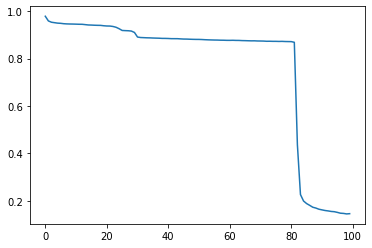

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('EPOCHS')
plt.show()

In [49]:
del l

In [54]:
del test

In [75]:
l = list(train_dataset.as_numpy_iterator())
print(len(l))
for i in range(1):
    x= model(l[i][0])
    print(x.shape)
z = np.reshape(x[0],(128,128))
c = np.reshape(l[0][1][1],(128,128))
z= cv2.resize(z,(300,300))
z = cv2.putText(z,'predicted',(20,20),cv2.FONT_HERSHEY_COMPLEX,1,(255,0,0),2)
c= cv2.resize(c,(300,300))
print(l)
while True:
    cv2.imshow("sd",z)
    cv2.imshow("s",c)
    cv2.waitKey(1)

29
(64, 128, 128, 1)
[(array([[[[0.40784314, 0.40784314],
         [0.40784314, 0.40784314],
         [0.4       , 0.4       ],
         ...,
         [0.30980392, 0.30980392],
         [0.3372549 , 0.3372549 ],
         [0.57254902, 0.57254902]],

        [[0.41568627, 0.41568627],
         [0.41568627, 0.41568627],
         [0.41568627, 0.41568627],
         ...,
         [0.30588235, 0.30588235],
         [0.57647059, 0.57647059],
         [0.56470588, 0.56470588]],

        [[0.42352941, 0.42352941],
         [0.42745098, 0.42745098],
         [0.43529412, 0.43529412],
         ...,
         [0.58431373, 0.58431373],
         [0.57254902, 0.57254902],
         [0.55294118, 0.55294118]],

        ...,

        [[0.07843137, 0.07843137],
         [0.07843137, 0.07843137],
         [0.07843137, 0.07843137],
         ...,
         [0.07058824, 0.07058824],
         [0.07058824, 0.07058824],
         [0.07058824, 0.07058824]],

        [[0.07843137, 0.07843137],
         [0.07843137, 0.

KeyboardInterrupt: 

In [ ]:
!pip freeze


absl-py==1.1.0
albumentations==1.3.0
asgiref==3.4.1
asttokens==2.0.5
astunparse==1.6.3
attrs==21.4.0
azure-cognitiveservices-vision-customvision==3.1.0
azure-common==1.1.28
azure-core==1.26.1
backcall==0.2.0
bbox-visualizer==0.1.0
boto3==1.22.5
botocore==1.25.5
cachetools==5.2.0
certifi==2022.5.18.1
charset-normalizer==2.0.12
colorama==0.4.5
cvzone==1.5.6
cycler==0.11.0
debugpy==1.6.3
decorator==5.1.1
deep-sort-realtime==1.3.1
Deprecated==1.2.13
distlib==0.3.4
distro==1.8.0
dj-database-url==0.5.0
Django==3.2.16
django-ckeditor==6.1.0
django-crispy-forms==1.12.0
django-filter==21.1
django-js-asset==1.2.2
django-phonenumber-field==5.2.0
django-storages==1.12.3
easyocr==1.6.2
editdistance==0.6.2
efficientnet==1.0.0
entrypoints==0.4
essential-generators==1.0
et-xmlfile==1.1.0
executing==0.8.3
filelock==3.7.1
flatbuffers==1.12
fonttools==4.33.3
future==0.18.2
gast==0.4.0
gitdb==4.0.10
GitPython==3.1.29
google-auth==2.6.6
google-auth-oauthlib==0.4.6
google-pasta==0.2.0
grpcio==1.46.3
gunicor